In [1]:
from pymatgen.core import Structure
from pymatgen.core.trajectory import Trajectory
from pymatgen.io.vasp.outputs import Xdatcar,Vasprun
# from pymatgen_diffusion.neb.pathfinder import IDPPSolver
# from pymatgen_diffusion.aimd.pathway import ProbabilityDensityAnalysis
# from pymatgen_diffusion.aimd.van_hove import VanHoveAnalysis
from pymatgen.analysis.transition_state import NEBAnalysis, combine_neb_plots
from matplotlib import pyplot as plt
from pymatgen.analysis.diffusion_analyzer import DiffusionAnalyzer,get_arrhenius_plot
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize
import re
import seaborn as sns
import pandas as pd
import copy
import matplotlib.image as mpimg # mpimg 用于读取图片
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/pymatgen/analysis/diffusion_analyzer.py:49: FutureWarning: All code in pymatgen.analysis.diffusion_analyzer has been moved to the separate add-on packagepymatgen-diffusion, which also includes a lot more functionality for analyzing diffusioncalculations. This module here is retained for backwards compatibility. It will be removed from2022.1.1.
  FutureWarning,


In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

config = {
    "font.family":'serif',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
    "font.weight":'bold'
}
rcParams.update(config)
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 25}
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [3]:

model_label_t = [
'$I43d-LiNiS_2$',
'$I43d-LiTiS_2$',
'$I43d-LiFeS_2$'
,'$I43d-LiCrS_2$'
,r'$\beta$-$Li_3PS_4$' 
,'$I43d-LiScS_2$'
,'$Li_2S$'       
,'$LiMn_2O_4$'  ,'$I43d-LiVS_2$'  
,'$Li_4Ti_5O_{12}$'  
,'$Li_3PO_4$'     
  
,'$Li_3AsS_4$' 
]    
model_label_o = [   
'$Li_2ScO_3$'
,'$Li_2TiO_3$'
,'$Li_2VO_3$'
,'$Li_2CrO_3$'
,'$Li_2MnO_3$'
,'$Li_2FeO_3$'
,'$Li_2CoO_3$'
,'$Li_2NiO_3$'
,'$LiCoO_2$'     
,'$P3m1-LiTiS_2$'
,'$R3m-LiTiS_2$' 

]

neb_model_t = [
    0.05,
    0.32,
0.066
,0.099
,0.26
,0.482
,0.48
,0.4,0.143
,0.36
,0.36

,0.3
]
neb_model_o = [
0.343
,0.489
,0.543
,0.586
,0.603
,0.641
,0.662
,0.68
,0.83
,0.7
,0.75

]
c_v_model_t = [
    0.32,0.28,
0.373
,0.307
,0.32
,0.485
    ,0.5
,0.46,0.355
,0.43
,0.4

,0.27]
c_v_model_o = [
0.3614
,0.4647
,0.6018
,0.6196
,0.6701
,0.7742
,0.7942
,0.8458
,0.82
,0.73
,0.66

]
c_v_d_model_t = [
    0.07,0.31,
0.13374
,0.15215
,0.28671535503833645
,0.48121
    ,0.5006446279738205
,0.4334250980213713,0.24313
,0.42272048172669296
,0.3711995389014022

,0.2351944122130457
]
c_v_d_model_o = [
0.31876
,0.42419
,0.51424
,0.52809
,0.57691
,0.68265
,0.698
,0.75059
,0.8244602188701569
,0.7465398645522869
,0.7154270849923025

]
csm_t = [1.35,0.15,
1.34628
,1.22424
,0.55937
,0.01896
,1.3073152582112596e-29
,0.11938679009972197#,1.309310898118240
,0.07203504252607407
,0.118169502842919
,0.3782354176810775
,0.23919155724458477
]
csm_o = [
1.25285
,1.61023
,1.7512
,1.83028
,1.86388
,1.831
,1.924
,1.90413
,0.329690771157112
,0.3314636158525157
,0.024920485234293365

]

In [4]:
data1 = {'model_label':model_label_t,'neb_model':neb_model_t,'c_v_model':c_v_model_t,'c_v_d_model':c_v_d_model_t,'csm':csm_t}
data2 = {'model_label':model_label_o,'neb_model':neb_model_o,'c_v_model':c_v_model_o,'c_v_d_model':c_v_d_model_o,'csm':csm_o}

In [5]:
df_t = pd.DataFrame(data1)
df_t = df_t.sort_values(axis=0,by='csm',ascending=False)
df_o = pd.DataFrame(data2)
df_o = df_o.sort_values(axis=0,by='csm',ascending=True)

In [6]:
df_r = df_t.append(df_o)

In [7]:
df_r

,model_label,neb_model,c_v_model,c_v_d_model,csm
0,$I43d-LiNiS_2$,0.050,0.3200,0.070000,1.350000e+00
2,$I43d-LiFeS_2$,0.066,0.3730,0.133740,1.346280e+00
3,$I43d-LiCrS_2$,0.099,0.3070,0.152150,1.224240e+00
4,$\beta$-$Li_3PS_4$,0.260,0.3200,0.286715,5.593700e-01
10,$Li_3PO_4$,0.360,0.4000,0.371200,3.782354e-01
11,$Li_3AsS_4$,0.300,0.2700,0.235194,2.391916e-01
1,$I43d-LiTiS_2$,0.320,0.2800,0.310000,1.500000e-01
7,$LiMn_2O_4$,0.400,0.4600,0.433425,1.193868e-01
9,$Li_4Ti_5O_{12}$,0.360,0.4300,0.422720,1.181695e-01
8,$I43d-LiVS_2$,0.143,0.3550,0.243130,7.203504e-02


0         $I43d-LiNiS_2$
2         $I43d-LiFeS_2$
3         $I43d-LiCrS_2$
4     $\beta$-$Li_3PS_4$
10            $Li_3PO_4$
11           $Li_3AsS_4$
1         $I43d-LiTiS_2$
7            $LiMn_2O_4$
9       $Li_4Ti_5O_{12}$
8          $I43d-LiVS_2$
5         $I43d-LiScS_2$
6                $Li_2S$
10         $R3m-LiTiS_2$
8              $LiCoO_2$
9         $P3m1-LiTiS_2$
0            $Li_2ScO_3$
1            $Li_2TiO_3$
2             $Li_2VO_3$
3            $Li_2CrO_3$
5            $Li_2FeO_3$
4            $Li_2MnO_3$
7            $Li_2NiO_3$
6            $Li_2CoO_3$
Name: model_label, dtype: object


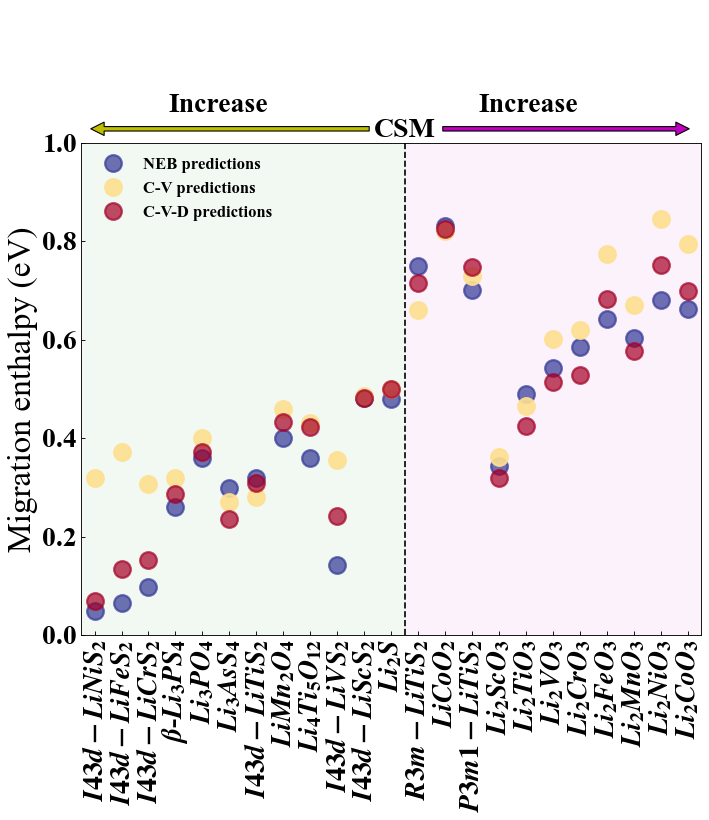

In [8]:
# xstick = volume_per_list
# xstick = anion_charge_list[elements]
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
plt.figure(figsize=(10,8),dpi=80)
# plt.xlim((-0.1,3))
# plt.ylim((-0.1,0.5))

a_plt = []

# marker_list =  ['-o', '-v', '-^', '-<','-p']
marker_list =  ['-o', '-v', '-^','-<','-p','-s',"->","-P","-*","-H","-+"]
num_plots = 6
colormap = plt.cm.RdYlBu_r
# cmap = mpl.cm.cool
color_array = [colormap(i) for i in np.linspace(0, 1, num_plots)]
# cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(vmin=5, vmax=10)
min, max = (-40, 30)
step = 20
mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['red','blue'])
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdYlBu_r)
cmap.set_array([])
# plt.clf()

x_lb = df_r['model_label']
neb_model1 = df_r['neb_model']
c_v_model1 = df_r['c_v_model']
c_v_d_model1 = df_r['c_v_d_model']
new_ticks = df_r['model_label']
print(x_lb)
t_plt,=plt.plot(x_lb,neb_model1,'o',
                 c=color_array[0], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,)
#                 markerfacecolor='none',)
#                     markerfacecolor='none')
t_plt1,=plt.plot(x_lb,c_v_model1,'o',c=color_array[3], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.9,)
t_plt2,=plt.plot(x_lb,c_v_d_model1,'o',c=color_array[-1], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,)
#                  markerfacecolor='none', )
#                      markerfacecolor='none')
#     t_plt,=plt.plot(df_delta.columns.tolist(),df_delta.iloc[int(xstick.index(k))].tolist(),'-*',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#                     markerfacecolor='none')
a_plt.append(t_plt)
a_plt.append(t_plt1)
a_plt.append(t_plt2)
#     print(a_plt)
# print(marker_list)
# markersize=15, linewidth=4,
#                  markeredgewidth=2
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])

# cbar = plt.colorbar(cmap,alpha=0.7)
# cbar.set_label(f'CSM',size=30)
# cbar.set_label(f'Anion Charge (e)',size=30)
# cbar.set_label(f'Volume per {elements} Atom($\AA^3$)',size=30)
plt.tick_params(labelsize=25)
# plt.xlim(0,len(model_label))
plt.ylim(0,1)
# plt.xlabel(f'Volume per S atoms $\AA^3$',font1)
# plt.ylabel(r'Ea(eV)',font1)
plt.ylabel(r'Migration enthalpy (eV)',size=30)
# plt.ylabel(r'$E_i^{tet}-E_i^{oct} (eV)$',font1)

plt.xticks(ticks=x_lb,labels=new_ticks,rotation=90,fontproperties = 'Times New Roman', size = 25)
form_str='form'
plt.title(f'',fontsize=30) #图片标题文本和字体大小
plt.yticks(fontproperties = 'Times New Roman', size = 25)
plt.axvline(x=len(x_lb)/2, color='k', linestyle='--')
plt.axvspan(-0.5, len(x_lb)/2, facecolor='g', alpha=0.05)
plt.axvspan(len(x_lb)/2, len(x_lb)-0.5, facecolor='m', alpha=0.05)
plt.annotate("", xy=(0.07, 1.08), xytext=(0.505,1.08),textcoords='figure fraction',xycoords='figure fraction',
             arrowprops=dict(facecolor="y", shrink=0.1, width=4))
plt.annotate("", xy=(0.9,1.08), xytext=(0.515, 1.08),textcoords='figure fraction',xycoords='figure fraction',
             arrowprops=dict(facecolor="m", shrink=0.1, width=4))
# plt.text(len(x_lb)*0.20,0.7,'four coordinates',verticalalignment="center",horizontalalignment="center")
# plt.text(len(x_lb)*0.70,0.1,'six coordinates',verticalalignment="center",horizontalalignment="center")
plt.text(len(x_lb)/2,1.0,'CSM',verticalalignment="bottom",horizontalalignment="center",fontsize=25)
plt.text(len(x_lb)*0.70,1.05,'Increase',verticalalignment="bottom",horizontalalignment="center",fontsize=25)
plt.text(len(x_lb)*0.20,1.05,'Increase',verticalalignment="bottom",horizontalalignment="center",fontsize=25)
# plt.xticks()
# plt.arrow(x=4, y=1.1, dx=2, dy=0,width=0.1)
# ax2 = plt.twiny()
l1 = plt.legend(a_plt,['NEB predictions','C-V predictions','C-V-D predictions'],loc='upper left',prop = {'size':15},frameon=False)
# l1 = plt.legend(a_plt,['Tet-Oct'],loc='upper left',prop = {'size':20},frameon=False)
plt.axis([-0.5,len(x_lb)-0.5,0,1])
# plt.tight()
plt.savefig(f'./figure4.png',bbox_inches='tight',dpi=600,pad_inches=0.0)

In [9]:
len(x_lb)

23

In [10]:
import math
def calculateMSE(X,Y): 
  return math.sqrt(sum([(y-x)**2 for x,y in zip(X,Y)])/len(X))

In [11]:
a = calculateMSE(df_r['neb_model'][3:12],df_r['c_v_model'][3:12])

In [12]:
a

0.08269959021798247